In [126]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import umap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [128]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a46bbf128>,
      dtype=object)

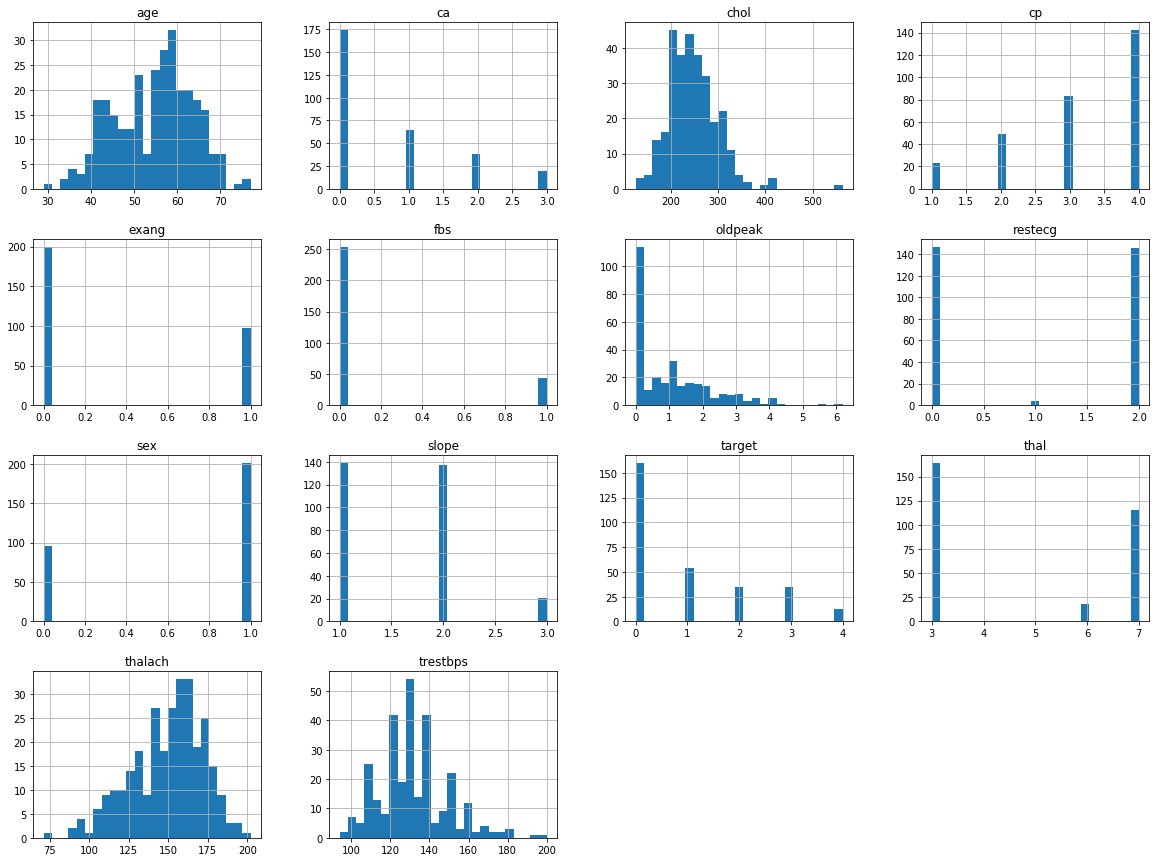

In [129]:
# raw_data = pd.read_csv("data/heart.csv")
# original_data = raw_data.drop(columns=["target"])
# training_labels = raw_data["target"]
# raw_data.head()

raw_data = pd.read_csv("data/original_heart.csv").astype(np.float64)
raw_data.hist(bins=25, figsize=(20,15))

In [130]:
# Categorical Types:
# Binary: sex, exang, fbs
# Multiclass: cp, restecg, thal

numerical_cols = ["age","trestbps","chol","thalach","slope","ca","oldpeak"]

original_data = raw_data.drop(columns=["oldpeak", "target"]).astype(np.int64)
original_data["oldpeak"] = raw_data["oldpeak"] # To keep it as a float
original_data = pd.get_dummies(original_data, 
                               columns=["cp","restecg","thal"],
                               prefix=["cp","restecg","thal"])


original_labels = raw_data["target"].astype(np.int64)

training_labels = raw_data["target"].astype(np.int64)
training_labels[training_labels > 0] = 1

print("Original Distribution:\n",original_labels.value_counts(), sep="")
print("Combined:\n",training_labels.value_counts(), sep="")

original_data.head()

Original Distribution:
0    160
1     54
3     35
2     35
4     13
Name: target, dtype: int64
Combined:
0    160
1    137
Name: target, dtype: int64


,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
0,63,1,145,233,1,150,0,3,0,2.3,1,0,0,0,0,0,1,0,1,0
1,67,1,160,286,0,108,1,2,3,1.5,0,0,0,1,0,0,1,1,0,0
2,67,1,120,229,0,129,1,2,2,2.6,0,0,0,1,0,0,1,0,0,1
3,37,1,130,250,0,187,0,3,0,3.5,0,0,1,0,1,0,0,1,0,0
4,41,0,130,204,0,172,0,1,0,1.4,0,1,0,0,0,0,1,1,0,0


In [131]:
original_data.shape

(297, 20)

In [132]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

#     dnn.add(Dense(units = 50, activation="elu", input_dim=num_features,
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 25, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units=10, activation='elu',
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    
    
    dnn.add(Dense(units = 25, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 25, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units=10, activation='elu',
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [133]:
## Need to define a scaling function that ignores categorical values...?

In [134]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                525       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 1,227
Trainable params: 1,227
Non-trainable params: 0
_________________________________________________________________


In [222]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.1)    

In [223]:
nn = build_dnn(num_features=original_data.shape[1])
pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)

pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)
_, sample_idxs = pipeline.train_clusterer(class_label=1, plot=False)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.464, Acc:0.8837
Prediction Accuracy
28/28 [==============================] - 0s 2ms/step
Scores on data set: loss=0.537 accuracy=0.8214
Fold Correct: 23
Running worker: 1
Fold: 1 -> Loss:0.484, Acc:0.8760
Prediction Accuracy
28/28 [==============================] - 0s 15us/step
Scores on data set: loss=0.457 accuracy=0.8929
Fold Correct: 25
Running worker: 2
Fold: 2 -> Loss:0.465, Acc:0.8798
Prediction Accuracy
28/28 [==============================] - 0s 15us/step
Scores on data set: loss=0.737 accuracy=0.8571
Fold Correct: 24
Running worker: 3
Fold: 3 -> Loss:0.478, Acc:0.8721
Prediction Accuracy
27/27 [==============================] - 0s 16us/step
Scores on data set: loss=0.562 accuracy=0.8148
Fold Correct: 22
Running worker: 4
Fold: 4 -> Loss:0.402, Acc:0.8923
Prediction Accuracy
26/26 [==============================] - 0s 18us/step
Scores on data set: loss=1.199 accuracy=0.6538
Fold Correct: 17
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.88194444 0.11805556]
 [0.20325203 0.79674797]]
Overall Accuracy: 0.8427


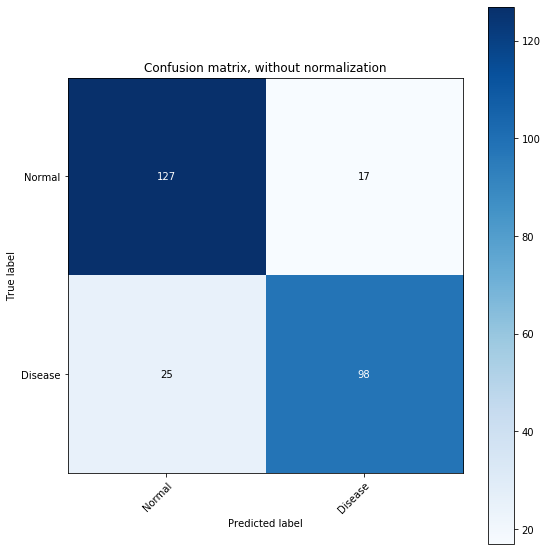

In [224]:
_, cm = plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

In [230]:
sample_idxs[pipeline.clusterer.labels_ == 0].sort_values()

Int64Index([  1,   2,  23,  24,  31,  40,  62,  65,  71,  72,  73,  96, 117,
            119, 125, 145, 154, 156, 157, 160, 172, 179, 187, 190, 202, 210,
            220, 221, 240, 245, 268, 282, 288, 291],
           dtype='int64')

In [231]:
nn2 = build_dnn(num_features=original_data.shape[1])
pipeline2 = ClusterPipeline(nn2, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)
pipeline2.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)
_, sample_idxs2 = pipeline2.train_clusterer(class_label=1, plot=False)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.449, Acc:0.8682
Prediction Accuracy
28/28 [==============================] - 0s 2ms/step
Scores on data set: loss=0.496 accuracy=0.8571
Fold Correct: 24
Running worker: 1
Fold: 1 -> Loss:0.501, Acc:0.8605
Prediction Accuracy
28/28 [==============================] - 0s 18us/step
Scores on data set: loss=0.483 accuracy=0.7857
Fold Correct: 22
Running worker: 2
Fold: 2 -> Loss:0.442, Acc:0.8992
Prediction Accuracy
28/28 [==============================] - 0s 18us/step
Scores on data set: loss=0.706 accuracy=0.8571
Fold Correct: 24
Running worker: 3
Fold: 3 -> Loss:0.465, Acc:0.8953
Prediction Accuracy
27/27 [==============================] - 0s 14us/step
Scores on data set: loss=0.593 accuracy=0.8148
Fold Correct: 22
Running worker: 4
Fold: 4 -> Loss:0.424, Acc:0.8885
Prediction Accuracy
26/26 [==============================] - 0s 14us/step
Scores on data set: loss=1.129 accuracy=0.6538
Fold Correct: 17
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.88888889 0.11111111]
 [0.20325203 0.79674797]]
Overall Accuracy: 0.8464


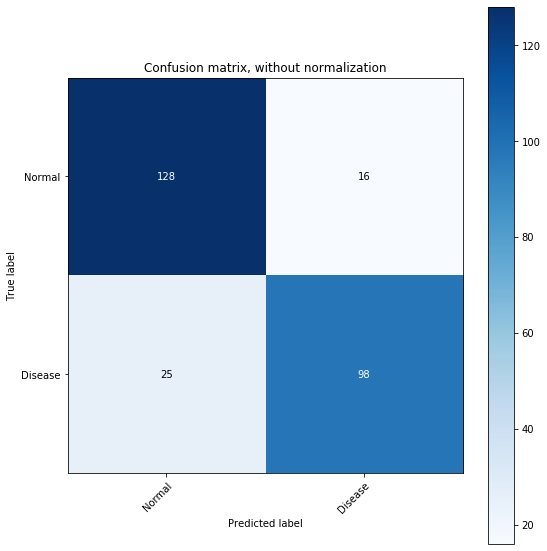

In [232]:
_, cm = plot_confusion_matrix(y_train.values[pipeline2.testing_idxs], np.array(pipeline2.predictions, dtype=int), np.array(["Normal", "Disease"]))

In [257]:
pd.Series(pipeline.clusterer.labels_).value_counts()

 0    34
 1    33
-1    31
dtype: int64

In [258]:
pd.Series(pipeline2.clusterer.labels_).value_counts()

0    58
1    40
dtype: int64

In [261]:
not_in_either = set(sample_idxs) ^ set(sample_idxs2)
not_in_either

{16, 106, 140, 142, 208, 226, 240, 243}

In [274]:
_set1 = set(sample_idxs[pipeline.clusterer.labels_ == 0])
_set2 = set(sample_idxs[pipeline.clusterer.labels_ == 1])
cluster_sets2 = set(sample_idxs2[pipeline2.clusterer.labels_ == 0])
cluster_sets1 = set(sample_idxs2[pipeline2.clusterer.labels_ == 1])

# We expect both runs to have "most" samples in clusters ot be common

In [266]:
_set1.isdisjoint(cluster_sets2) #- not_in_either

True

In [268]:
_set2.isdisjoint(cluster_sets2)

False

In [273]:
_set2.difference(cluster_sets2)

{243}

In [275]:
_set2.symmetric_difference(cluster_sets2)

{9,
 16,
 47,
 55,
 56,
 107,
 110,
 112,
 113,
 118,
 135,
 136,
 140,
 153,
 168,
 175,
 208,
 225,
 226,
 228,
 233,
 243,
 244,
 248,
 261,
 276,
 287}

In [276]:
_set1.difference(cluster_sets1)

{240}

In [277]:
_set1.symmetric_difference(cluster_sets1)

{6, 90, 120, 189, 232, 240, 281, 294}

# ^ to automate this, just loop and find the maximum common pairs of sets and then plot a ven diagram or something

In [138]:
# min_cluster_sizes=range(3,20,1)
pipeline.train_clusterer(class_label=1, plot=False)

Minimum Size:
Clusters                  (12, 12)
Noise                     (12, 12)
Halkidi                   (12, 12)
Halkidi-Filtered Noise    (12, 12)
dtype: object


,Clusters,Noise,Halkidi,Halkidi-Filtered Noise
"(12, 12)",2,0.0,0.319554,0.319554
"(13, 12)",2,0.0,0.319554,0.319554
"(13, 13)",2,0.0,0.319554,0.319554
"(14, 12)",2,0.0,0.319554,0.319554
"(14, 13)",2,0.0,0.319554,0.319554
"(14, 14)",2,0.0,0.319554,0.319554
"(15, 12)",2,0.0,0.319554,0.319554
"(15, 13)",2,0.0,0.319554,0.319554
"(15, 14)",2,0.0,0.319554,0.319554
"(15, 15)",2,0.0,0.319554,0.319554


In [139]:
pipeline.training_lrp.shape

(99, 20)

In [140]:
pd.Series(pipeline.clusterer.labels_).value_counts()

1    59
0    40
dtype: int64

In [141]:
# Internally populates self.val_set_lrp
samples, cluster_labels = pipeline.get_validation_clusters()

Loading LRP Analyzers...
Done!
Prediction Accuracy: 0.8667


In [142]:
pd.Series(cluster_labels).value_counts()

1    8
0    4
dtype: int64

In [143]:
pipeline.target_class

1

## Plotting Relevance Clusters

In [144]:
training_lrp = pipeline.training_lrp
val_lrp = pipeline.val_set_lrp
training_lrp.shape

(99, 20)

In [145]:
# pipeline.reducer_pipeline[0].n_neighbors
embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(training_lrp)

embedding = embedding_pipeline.transform(training_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=5,
        color=pipeline.clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8
    ),
    text=pipeline.clusterer.labels_
)

val_3d_embedding = embedding_pipeline.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    name="Validation",
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
#         showscale=True
    ),
    text = cluster_labels
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5',
#     template="plotly"
)


data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
# fig.update_layout(template="plotly")  /

iplot(fig, filename='lrp-3d-scatter.html')

# Performing Feature Reduction

In [146]:
def get_relevant_cols(df, thresh = 1e-2):

    all_above_thresh = (df < thresh).all(0) #Check if all values in columns satisfy the criteria
    max_above_thresh = (df.max() < thresh)
    quantile_above_thresh = (df.quantile(0.8) <= thresh)

    criteria = quantile_above_thresh
    irrelevant_cols = df.columns[criteria] 
    irrelevant_cols
    
    relevant_features_only = df.drop(columns = irrelevant_cols)
    
    return relevant_features_only

## Getting largest subcluster samples from validation set

In [147]:
subcluster_labels = range(0,max(pipeline.clusterer.labels_)+1)

# Get testing samples from cross validation
reindexer = pipeline.testing_idxs

# That were correctly predicted
correct_preds = pipeline.correct_preds_bool_arr

# Separating Control from Target
target_samples  = y_train.iloc[reindexer][correct_preds] == pipeline.target_class
control_samples = ~target_samples

target_class_features = X_train.iloc[reindexer][correct_preds][target_samples]
target_class_labels   = y_train.iloc[reindexer][correct_preds][target_samples]
target_class_features.head()

,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
122,55,1,140,217,0,111,1,3,0,5.6,0,0,0,1,1,0,0,0,0,1
24,60,1,130,206,0,132,1,2,2,2.4,0,0,0,1,0,0,1,0,0,1
137,35,1,120,198,0,130,1,2,0,1.6,0,0,0,1,1,0,0,0,0,1
79,58,1,150,270,0,111,1,1,0,0.8,0,0,0,1,0,0,1,0,0,1
120,63,0,150,407,0,154,0,2,3,4.0,0,0,0,1,0,0,1,0,0,1


In [148]:
target_class_features.shape

(99, 20)

In [149]:
pipeline.target_class

1

In [150]:
target_size = len(target_class_labels)
control_features = X_train[y_train != pipeline.target_class][:target_size]
# control_features = control_features[:target_size]
control_labels = y_train[y_train != pipeline.target_class][:target_size]

correct_predictions_features = pd.concat([control_features, target_class_features], axis="index")
correct_predictions_labels = pd.concat([control_labels, target_class_labels], axis="index")

## Using reduced features for retraining

> **Only values from the same cluster can be retrained**

In [197]:
cluster_train = {}

for cluster_label in subcluster_labels:
    
    tsamples = target_class_features[(pipeline.clusterer.labels_ == cluster_label)]
    tlabels  = target_class_labels[(pipeline.clusterer.labels_ == cluster_label)]
    print("Target:", tsamples.index, tlabels.index)

#     csamples = X_train.iloc[reindexer][correct_preds][control_samples]
    csamples = X_train[y_train != pipeline.target_class]
    csamples = csamples[:len(tsamples)]

#     clabels = y_train.iloc[reindexer][correct_preds][control_samples]
    clabels = y_train[y_train != pipeline.target_class]
    clabels = clabels[:len(tsamples)]
#     print("Control:", csamples.index, clabels.index)
    
    _clustered = pd.DataFrame(training_lrp[(pipeline.clusterer.labels_ == cluster_label)],
                              columns = X_train.columns)
    
#     thresh = min(val_clustered.describe().loc["75%"])
    thresh = _clustered.max().min()
    print(thresh)
    reduced_cols = get_relevant_cols(_clustered, thresh=thresh).columns
    print(reduced_cols, len(reduced_cols))
    
    tsamples = tsamples[reduced_cols]
    csamples  = csamples[reduced_cols]
    
    
    
    # Now stack it with control values of same size...
    X_train_sc = pd.concat([csamples, tsamples], axis="index")
    y_train_sc = pd.concat([clabels, tlabels], axis="index")
    
    cluster_train[cluster_label] = (X_train_sc, y_train_sc)


Target: Int64Index([ 24, 120, 220, 232, 189, 179, 288, 291, 156,  65,   2, 172, 154,
            160,   6, 281,  31, 268, 145, 221, 294, 245,  73, 282,   1, 187,
             62, 190, 157, 119,  90, 125,  23,  72, 202,  96, 117, 210,  40,
             71],
           dtype='int64') Int64Index([ 24, 120, 220, 232, 189, 179, 288, 291, 156,  65,   2, 172, 154,
            160,   6, 281,  31, 268, 145, 221, 294, 245,  73, 282,   1, 187,
             62, 190, 157, 119,  90, 125,  23,  72, 202,  96, 117, 210,  40,
             71],
           dtype='int64')
0.0
Index(['sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'slope', 'ca',
       'oldpeak', 'cp_1', 'cp_3', 'cp_4', 'restecg_0', 'restecg_2', 'thal_3',
       'thal_6', 'thal_7'],
      dtype='object') 17
Target: Int64Index([122, 137,  79, 248, 110,  45,  55, 136, 155,  36,  37,   8, 243,
            244, 175,  83,  60, 135, 234,  38,  29, 142, 108,  16,  76,  54,
            228, 178, 208, 225,  47, 292, 126, 107, 276, 105, 118, 15

In [200]:
target_class_features.head()

,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
122,55,1,140,217,0,111,1,3,0,5.6,0,0,0,1,1,0,0,0,0,1
24,60,1,130,206,0,132,1,2,2,2.4,0,0,0,1,0,0,1,0,0,1
137,35,1,120,198,0,130,1,2,0,1.6,0,0,0,1,1,0,0,0,0,1
79,58,1,150,270,0,111,1,1,0,0.8,0,0,0,1,0,0,1,0,0,1
120,63,0,150,407,0,154,0,2,3,4.0,0,0,0,1,0,0,1,0,0,1


In [202]:
target_class_features.reindex(tsamples.index)

,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
122,55,1,140,217,0,111,1,3,0,5.6,0,0,0,1,1,0,0,0,0,1
137,35,1,120,198,0,130,1,2,0,1.6,0,0,0,1,1,0,0,0,0,1
79,58,1,150,270,0,111,1,1,0,0.8,0,0,0,1,0,0,1,0,0,1
248,58,1,146,218,0,105,0,2,1,2.0,0,0,0,1,1,0,0,0,0,1
110,56,1,125,249,1,144,1,2,1,1.2,0,0,0,1,0,0,1,1,0,0
45,58,1,112,230,0,165,0,2,1,2.5,0,0,1,0,0,0,1,0,0,1
55,54,1,124,266,0,109,1,2,1,2.2,0,0,0,1,0,0,1,0,0,1
136,62,1,120,281,0,103,0,2,1,1.4,0,1,0,0,0,0,1,0,0,1
155,51,1,140,299,0,173,1,1,0,1.6,0,0,0,1,1,0,0,0,0,1
36,43,1,120,177,0,120,1,2,0,2.5,0,0,0,1,0,0,1,0,0,1


In [152]:
_clustered.describe()

,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.057327,0.230770,0.164946,0.064342,0.021827,0.063111,0.370725,0.417903,0.185651,0.448587,0.122594,0.019684,0.284851,0.403442,0.067424,0.025151,0.121122,0.412301,0.022946,0.555999
std,0.103204,0.103343,0.297175,0.115028,0.040208,0.096767,0.268775,0.401435,0.179766,0.547645,0.031904,0.087703,0.111971,0.219149,0.085944,0.135605,0.129842,0.195605,0.021241,0.295564
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.212125,0.000000,0.000000,0.000000,0.000000,0.000000,0.236443,0.000000,0.000000,0.101823,0.000000,0.266900,0.349641,0.000000,0.000000,0.000000,0.301518,0.000000,0.488201
50%,0.000000,0.250795,0.000000,0.000000,0.000874,0.026533,0.434096,0.334929,0.247839,0.245014,0.127792,0.000000,0.305946,0.439833,0.001196,0.000000,0.106538,0.467819,0.018328,0.638428
75%,0.076368,0.297983,0.215518,0.076822,0.029793,0.078173,0.555434,0.439038,0.341767,0.765886,0.142079,0.000000,0.347160,0.558702,0.143262,0.000000,0.240735,0.525172,0.040539,0.728914
max,0.473311,0.397949,1.598472,0.512639,0.215261,0.437459,0.844994,1.643294,0.495116,2.600803,0.177560,0.489123,0.455447,0.872296,0.277494,0.779821,0.370945,0.776883,0.077213,1.045540


In [153]:
srtd_metrics = _clustered.describe().loc[["mean","75%","max"]].sort_values(by=["mean", "75%", "max"], axis=1)

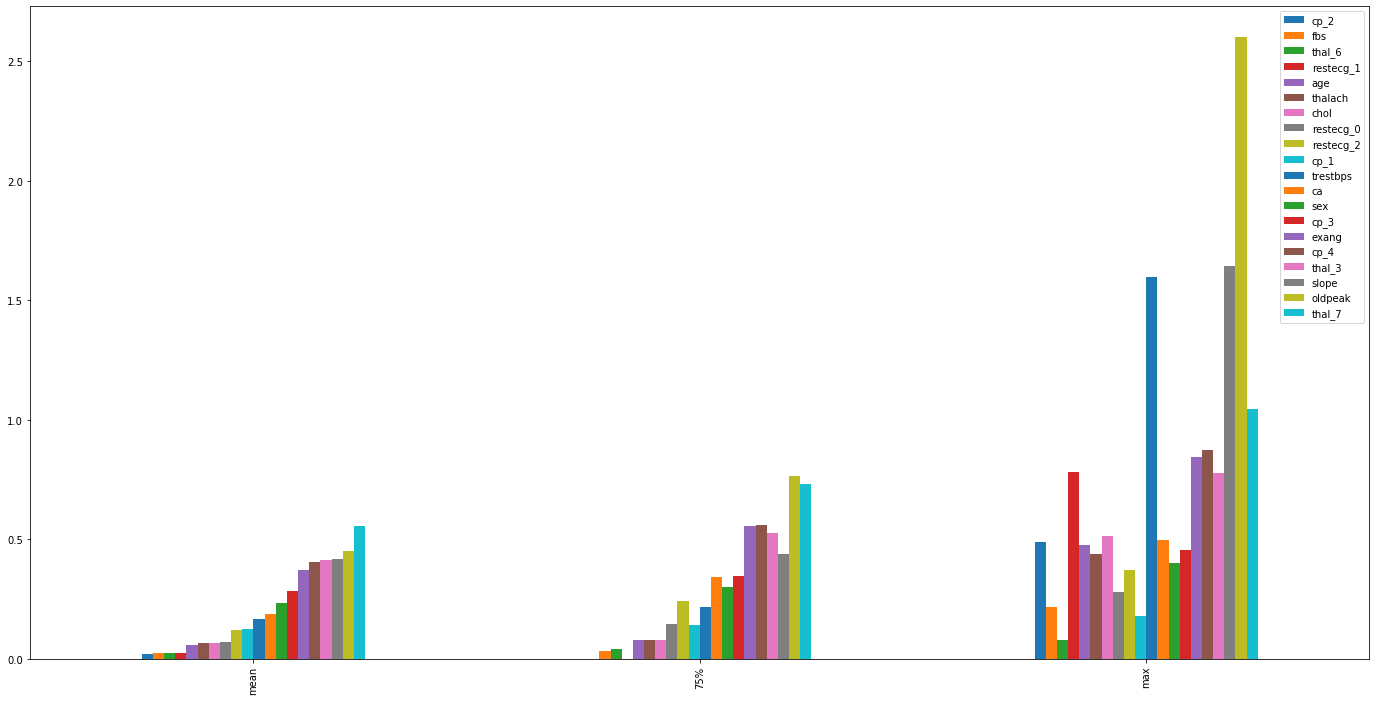

In [154]:
srtd_metrics.plot(kind="bar", figsize=(24,12))

### Baseline CN vs Subcluster

> **Reusing the same network architecture may not be valid as the samples are already biased towards it**

In [163]:
def runSubclusterAnalysis(cluster_train, dnn_build_fn, batch_size=20, epochs=100):
    results = {}
    pipelines = {}
    
    for sc in cluster_train:
        X_train_sc, y_train_sc = cluster_train[sc]

        # All the samples from X_valid are used for now...
        X_valid_red = X_valid[X_train_sc.columns]

        nn = dnn_build_fn(num_features=X_train_sc.shape[1])

        _pipeline = ClusterPipeline(nn, [X_train_sc, y_train_sc], [X_valid_red, y_valid], target_class=1)
        _pipeline.train_model(batch_size=batch_size,epochs=epochs, cross_validation=True, parallel=False, verbose=0)

        _, cm = plot_confusion_matrix(y_train_sc.values[_pipeline.testing_idxs],
                              np.array(_pipeline.predictions, dtype=int),
                              np.array(["Normal", "Disease"]))
        results[sc] = cm
        pipelines[sc] = _pipeline
    
    correct = sum([np.trace(results[sc]) for sc in results])
    total   = sum([sum(results[sc].ravel()) for sc in results])
    print("Analysis Accuracy: {:.4f}".format(correct/total))
    
    return results, pipelines

In [164]:
non_red_cluster_train = pipeline.getSubclusters(reduce=False)

# %time baseline_results = runSubclusterAnalysis(non_red_cluster_train, build_dnn)

# Feeding models (feature) reduced data

In [165]:
cluster_train = pipeline.getSubclusters(reduce=True)
print(cluster_train[0][0].columns)
print(cluster_train[1][0].columns)

Index(['sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'slope', 'ca',
       'oldpeak', 'cp_1', 'cp_3', 'cp_4', 'restecg_0', 'restecg_2', 'thal_3',
       'thal_6', 'thal_7'],
      dtype='object')
Index(['age', 'sex', 'trestbps', 'chol', 'thalach', 'exang', 'slope', 'ca',
       'oldpeak', 'cp_1', 'cp_3', 'cp_4', 'restecg_0', 'restecg_2', 'thal_3',
       'thal_7'],
      dtype='object')


## Original architecture

### Accuracy is same as w/ original feature set
> **This is a sign that the features dropped were in fact not very useful for classifying *this* subcluster**

In [166]:
# %time baseline_reduced_results = runSubclusterAnalysis(cluster_train, build_dnn)

# Shallow Network

## Rebuilding a (simpler) DNN architecture

In [167]:
def build_shallow_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 15, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 10, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=5, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

### Accuracy is same as w/ original architecture

- **Using a different network architecture removes any potential sources of bias of reusing the same samples for the same network**
- **Using a shallower n/w shows us that a "simpler" classifier can work**

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.242, Acc:0.9167
Prediction Accuracy
8/8 [==============================] - 0s 5ms/step
Scores on data set: loss=0.518 accuracy=0.8750
Fold Correct: 7
Running worker: 1
Fold: 1 -> Loss:0.210, Acc:0.9722
Prediction Accuracy
8/8 [==============================] - 0s 55us/step
Scores on data set: loss=0.283 accuracy=0.8750
Fold Correct: 7
Running worker: 2
Fold: 2 -> Loss:0.241, Acc:0.9306
Prediction Accuracy
8/8 [==============================] - 0s 45us/step
Scores on data set: loss=0.109 accuracy=1.0000
Fold Correct: 8
Running worker: 3
Fold: 3 -> Loss:0.380, Acc:0.8472
Prediction Accuracy
8/8 [==============================] - 0s 48us/step
Scores on data set: loss=0.236 accuracy=0.8750
Fold Correct: 7
Running worker: 4
Fold: 4 -> Loss:0.219, Acc:0.9583
Prediction Accuracy
8/8 [==============================] - 0s 60us/step
Scores on data set: loss=0.104 accuracy=1.0000
Fold Correct: 8
Running worker: 5
Fold: 5 -> Loss:0

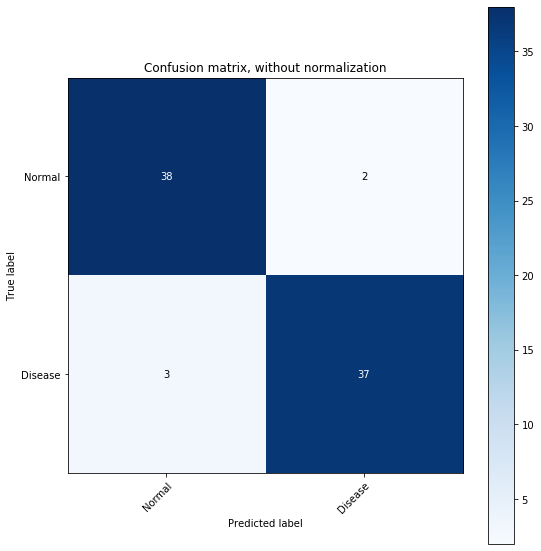

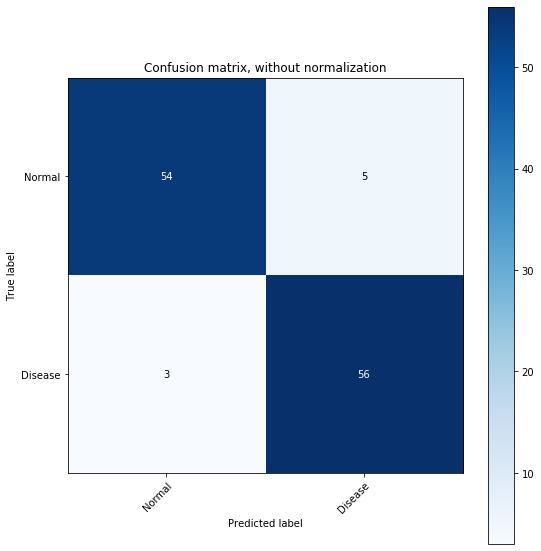

In [184]:
%time shallow_nw_results, pipelines = runSubclusterAnalysis(cluster_train, build_shallow_dnn, batch_size=20, epochs=30)

In [209]:
X_val_sc, y_val_sc = cluster_train[1]
print(X_val_sc["sex"].tail())
y_val_sc.tail()

113    0
112    0
204    1
173    1
186    1
Name: sex, dtype: int64


113    1
112    1
204    1
173    1
186    1
Name: target, dtype: int64

In [211]:
target_sc_idx = X_val_sc[y_val_sc == pipeline.target_class].index

target_class_features.reindex(target_sc_idx)[X_train_sc.columns].tail()

,age,sex,trestbps,chol,thalach,exang,slope,ca,oldpeak,cp_1,cp_3,cp_4,restecg_0,restecg_2,thal_3,thal_7
113,62,0,130,263,97,0,2,1,1.2,0,1,0,1,0,0,1
112,43,0,132,341,136,1,2,0,3.0,0,0,1,0,1,0,1
204,50,1,144,200,126,1,2,0,0.9,0,0,1,0,1,0,1
173,57,1,152,274,88,1,2,1,1.2,0,0,1,1,0,0,1
186,54,1,192,283,195,0,1,1,0.0,0,0,0,0,1,0,1


In [217]:
(1+1)%len(cluster_train)

0

# TODO: LOAD SCALERS INTO MEMORY AFTER TRAINING IS FINISHED

In [218]:
sc = 1

X_train_sc, y_train_sc = cluster_train[sc]
X_val_sc, y_val_sc = cluster_train[(sc+1)%len(cluster_train)]

target_sc_idx = X_val_sc[y_val_sc == pipeline.target_class].index

X_val_sc = target_class_features[X_train_sc.columns].reindex(target_sc_idx)
y_val_sc = target_class_labels.reindex(target_sc_idx)

pipelines[sc].val_set = ClusterPipeline.Dataset(X_val_sc, y_val_sc)
pipelines[sc].get_predictions()

Prediction Accuracy: 1.0000


(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 0, 1, 1, 0, 1, 3, 6, 4, 0, 1, 3, 1, 3, 3, 0, 4, 1, 0, 3, 1, 3,
        3, 3, 1, 1, 0, 3, 3, 4, 0, 0, 9, 1, 1, 3, 0, 4, 1, 1]))

In [214]:
pipelines[sc].numerical_cols

Index(['sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'slope', 'ca',
       'oldpeak', 'cp_1', 'cp_3', 'cp_4', 'restecg_0', 'restecg_2', 'thal_3',
       'thal_6', 'thal_7'],
      dtype='object')

In [215]:
X_val_sc.columns

Index(['sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'slope', 'ca',
       'oldpeak', 'cp_1', 'cp_3', 'cp_4', 'restecg_0', 'restecg_2', 'thal_3',
       'thal_6', 'thal_7'],
      dtype='object')

In [96]:
correct = sum([np.trace(shallow_nw_results[sc]) for sc in shallow_nw_results])
total = sum([sum(shallow_nw_results[sc].ravel()) for sc in shallow_nw_results])
print("Analysis Accuracy: {:.4f}".format(correct/total))

Analysis Accuracy: 0.9337


- ### Better accuracy than original architecure being fed reduced features
- # Generally beats original non-subclustered analysis
- ### Not as good as orginal with subclustered data
    - **Thats expected however due to the implicit bias in the subclusters**


## NN w/ ALL features
- ### Performs just as well as original architecure with subcluster

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.292, Acc:0.9510
Prediction Accuracy
12/12 [==============================] - 0s 3ms/step
Scores on data set: loss=0.121 accuracy=1.0000
Fold Correct: 12
Running worker: 1
Fold: 1 -> Loss:0.356, Acc:0.9020
Prediction Accuracy
12/12 [==============================] - 0s 32us/step
Scores on data set: loss=0.456 accuracy=0.9167
Fold Correct: 11
Running worker: 2
Fold: 2 -> Loss:0.366, Acc:0.9314
Prediction Accuracy
12/12 [==============================] - 0s 45us/step
Scores on data set: loss=0.300 accuracy=0.9167
Fold Correct: 11
Running worker: 3
Fold: 3 -> Loss:0.294, Acc:0.9314
Prediction Accuracy
12/12 [==============================] - 0s 38us/step
Scores on data set: loss=0.123 accuracy=1.0000
Fold Correct: 12
Running worker: 4
Fold: 4 -> Loss:0.252, Acc:0.9314
Prediction Accuracy
12/12 [==============================] - 0s 41us/step
Scores on data set: loss=0.923 accuracy=0.8333
Fold Correct: 10
Running worker: 5
Fo

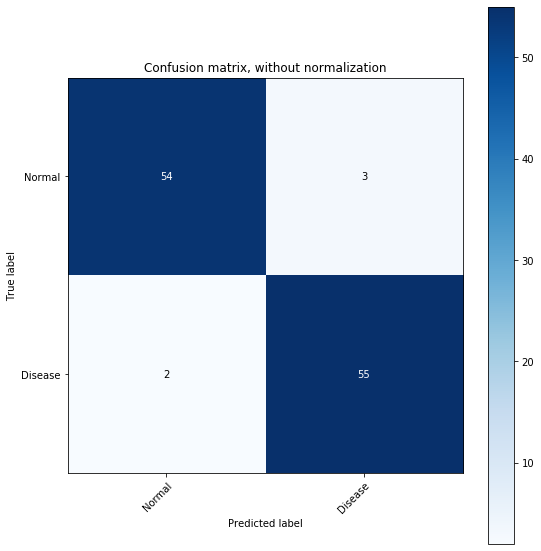

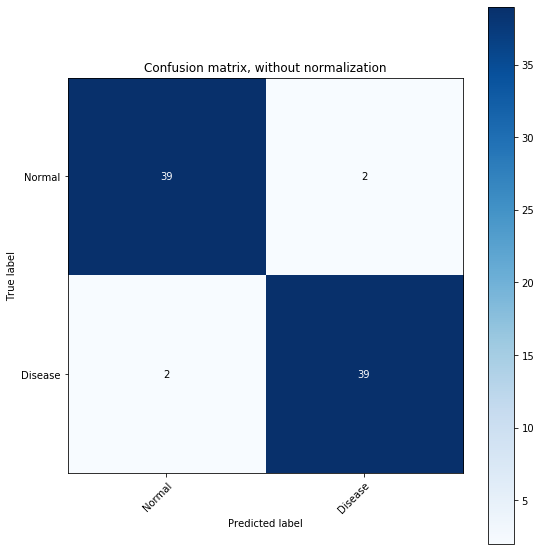

In [100]:
# non_red_cluster_train = pipeline.getSubclusters(reduce=False)
%time shallow_nw_results = runSubclusterAnalysis(non_red_cluster_train, build_shallow_dnn, batch_size=20, epochs=30)

## NN w/ well biased (well-separated) samples

In [75]:
#### Skipping for now ####
nn = build_shallow_dnn(num_features=X_train.shape[1])

shallow_pipeline = ClusterPipeline(nn, [correct_predictions_features, correct_predictions_labels], [X_valid, y_valid], target_class=1)

shallow_pipeline.train_model(batch_size=20,epochs=30, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.247, Acc:0.9432
Prediction Accuracy
20/20 [==============================] - 0s 2ms/step
Scores on data set: loss=0.458 accuracy=0.8500
Fold Correct: 17
Running worker: 1
Fold: 1 -> Loss:0.248, Acc:0.9261
Prediction Accuracy
20/20 [==============================] - 0s 25us/step
Scores on data set: loss=0.211 accuracy=0.9500
Fold Correct: 19
Running worker: 2
Fold: 2 -> Loss:0.333, Acc:0.9261
Prediction Accuracy
20/20 [==============================] - 0s 30us/step
Scores on data set: loss=0.221 accuracy=0.9500
Fold Correct: 19
Running worker: 3
Fold: 3 -> Loss:0.257, Acc:0.9375
Prediction Accuracy
20/20 [==============================] - 0s 31us/step
Scores on data set: loss=0.326 accuracy=0.9500
Fold Correct: 19
Running worker: 4
Fold: 4 -> Loss:0.306, Acc:0.9375
Prediction Accuracy
20/20 [==============================] - 0s 32us/step
Scores on data set: loss=0.255 accuracy=0.9000
Fold Correct: 18
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.92857143 0.07142857]
 [0.08163265 0.91836735]]
Overall Accuracy: 0.9235


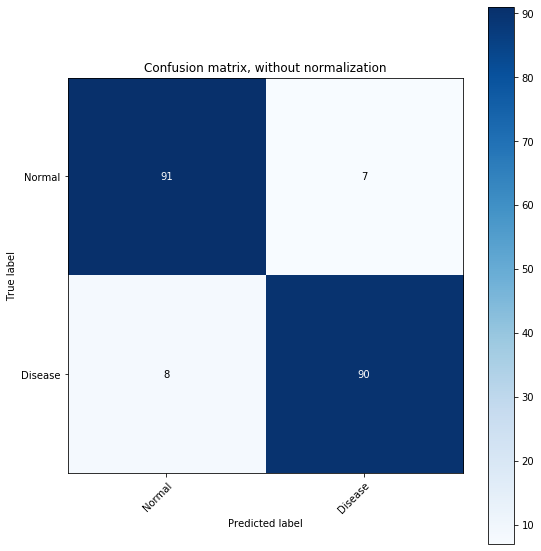

In [76]:
_,cm = plot_confusion_matrix(correct_predictions_labels.values[shallow_pipeline.testing_idxs], np.array(shallow_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

## Shallow on Original Network

In [98]:
nn = build_shallow_dnn(num_features=X_train.shape[1])

shallow_pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid, y_valid], target_class=1)

shallow_pipeline.train_model(batch_size=20,epochs=30, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.513, Acc:0.8488
Prediction Accuracy
28/28 [==============================] - 0s 1ms/step
Scores on data set: loss=0.379 accuracy=0.8929
Fold Correct: 25
Running worker: 1
Fold: 1 -> Loss:0.508, Acc:0.8333
Prediction Accuracy
28/28 [==============================] - 0s 18us/step
Scores on data set: loss=0.490 accuracy=0.7857
Fold Correct: 22
Running worker: 2
Fold: 2 -> Loss:0.513, Acc:0.8411
Prediction Accuracy
28/28 [==============================] - 0s 15us/step
Scores on data set: loss=0.599 accuracy=0.8214
Fold Correct: 23
Running worker: 3
Fold: 3 -> Loss:0.477, Acc:0.8682
Prediction Accuracy
27/27 [==============================] - 0s 13us/step
Scores on data set: loss=0.484 accuracy=0.8519
Fold Correct: 23
Running worker: 4
Fold: 4 -> Loss:0.431, Acc:0.8808
Prediction Accuracy
26/26 [==============================] - 0s 17us/step
Scores on data set: loss=0.902 accuracy=0.6923
Fold Correct: 18
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.86111111 0.13888889]
 [0.20325203 0.79674797]]
Overall Accuracy: 0.8315


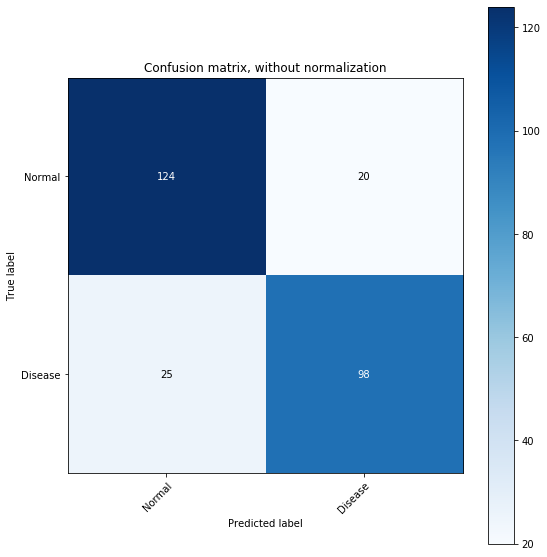

In [99]:
_,cm = plot_confusion_matrix(y_train.values[shallow_pipeline.testing_idxs], np.array(shallow_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

# SVM Analysis

In [120]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


param_grid = [
    {"dual":[False],"max_iter":[10000000], "penalty":["l1","l2"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["squared_hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]}
]

lsvc = LinearSVC()


clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM",LinearSVC())
])

def runSVM(X,y, X_valid,y_valid):
    np.random.seed(42)
    clf_grid = Pipeline([
        ("scaler", StandardScaler()),
        ("SVMGrid",GridSearchCV(lsvc, param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=4))
    ])
    
    clf_grid.fit(X, y)
    grid = clf_grid.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("SVM", LinearSVC(**grid.best_params_))
    ])
    
    svm_clf.fit(X, y)
    print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

    _score = cross_val_score(svm_clf, X=X, y=y, cv=10)
    print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
    return svm_clf, _score.mean()

## SVM trained on original data

In [111]:
original_svm, score = runSVM(X_train, y_train, X_valid, y_valid)

{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.767
SVM CV Accuracy: 0.846(+/- 0.143)


## SVM trained on biased data -- Baseline
> Both subclusters vs control

In [112]:
original_svm, score = runSVM(correct_predictions_features, correct_predictions_labels, X_valid, y_valid)

{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.733
SVM CV Accuracy: 0.943(+/- 0.073)


## Trained on subcluster vs control only

In [121]:
%%time 
scores = []
sizes = []

for sc in non_red_cluster_train:
    X_train_sc, y_train_sc = non_red_cluster_train[sc]
    X_valid_red = X_valid[X_train_sc.columns]
    _clf, _score = runSVM(X_train_sc, y_train_sc, X_valid_red, y_valid)
    scores.append(_score)
    sizes.append(len(X_train_sc))

{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 0.767
SVM CV Accuracy: 0.947(+/- 0.088)
{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.767
SVM CV Accuracy: 0.963(+/- 0.115)
CPU times: user 412 ms, sys: 8.61 ms, total: 421 ms
Wall time: 4.3 s


In [122]:
# This is actually the "true" mean: sum(correctly classified) / (total samples)
weighted_avg = sum([sz*sc.mean() for sz,sc in zip(sizes, scores)])/sum(sizes)
print("Weighted Mean: {:0.4f}".format(weighted_avg))

Weighted Mean: 0.9533


## Trained on feature reduced subcluster
> ### Despite losing some features, we still retain a high accuracy
> ### This may be an indication that the subclustering was infact a valid one

In [123]:
scores = []
sizes  = []

for sc in cluster_train:
    X_train_sc, y_train_sc = cluster_train[sc]
    X_valid_red = X_valid[X_train_sc.columns]
    _clf, _score = runSVM(X_train_sc, y_train_sc, X_valid_red, y_valid)
    scores.append(_score)
    sizes.append(len(X_train_sc))

{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 0.767
SVM CV Accuracy: 0.938(+/- 0.111)
{'C': 10, 'dual': False, 'max_iter': 10000000, 'penalty': 'l2', 'tol': 0.0001}
SVM Test Accuracy: 0.733
SVM CV Accuracy: 0.975(+/- 0.100)


In [124]:
weighted_avg = sum([sz*sc.mean() for sz,sc in zip(sizes, scores)])/sum(sizes)
print("Weighted Mean: {:0.4f}".format(weighted_avg))

Weighted Mean: 0.9537
